In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
import itertools
import shutil


In [ ]:
INPUT_DIRECTORY = '/content/Input'
OUTPUT_DIRECTORY = '/content/Output'

In [ ]:
parent_list = os.listdir(INPUT_DIRECTORY)
for i in range(3):
    print(parent_list[i])

MYOPATHY5.wav
MYOPATHY12.wav
neuropathy8.wav


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


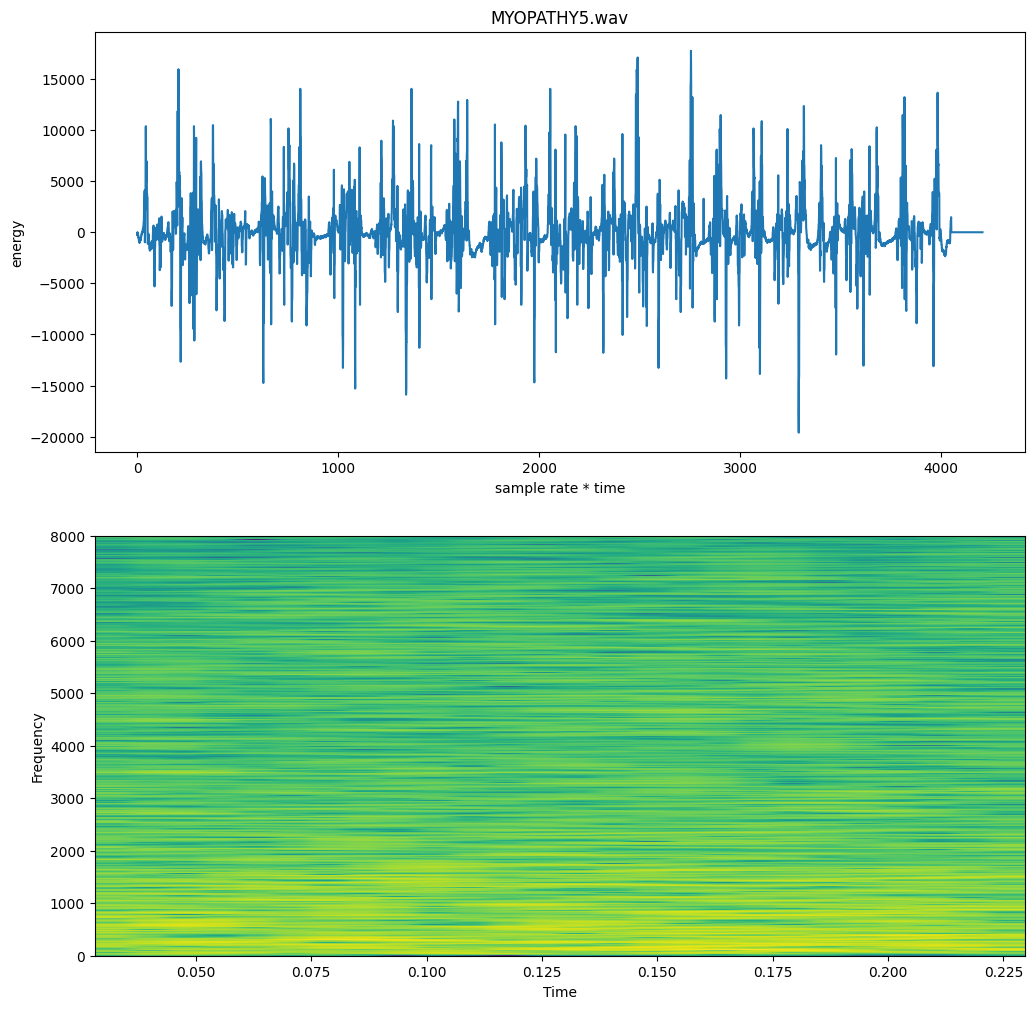

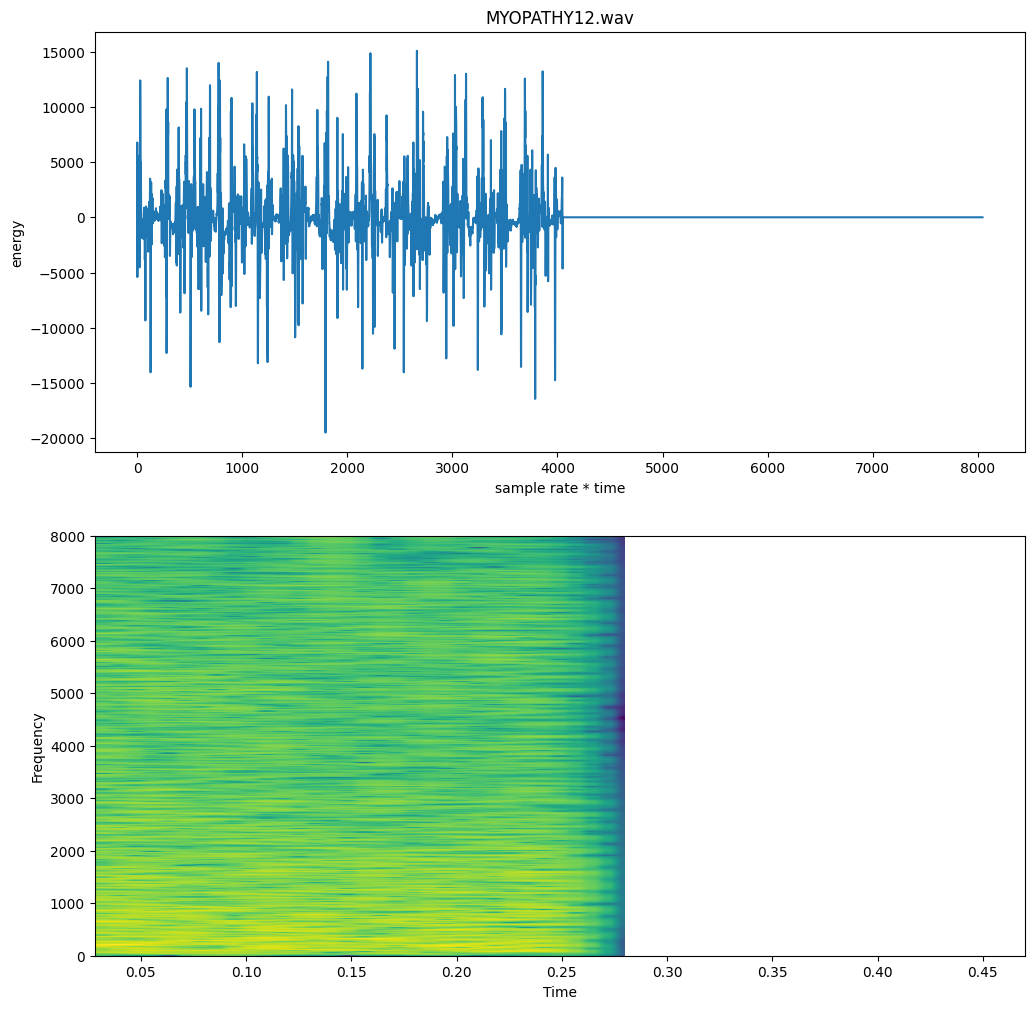

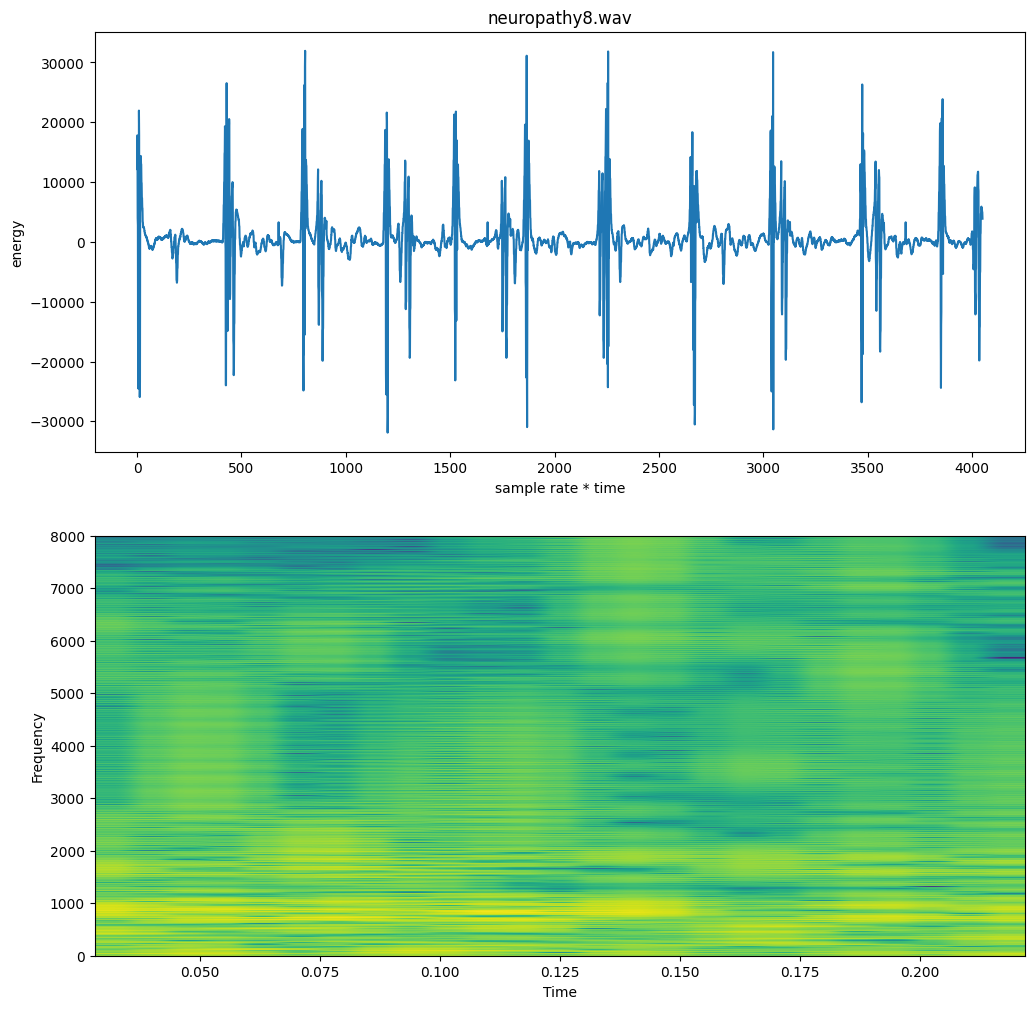

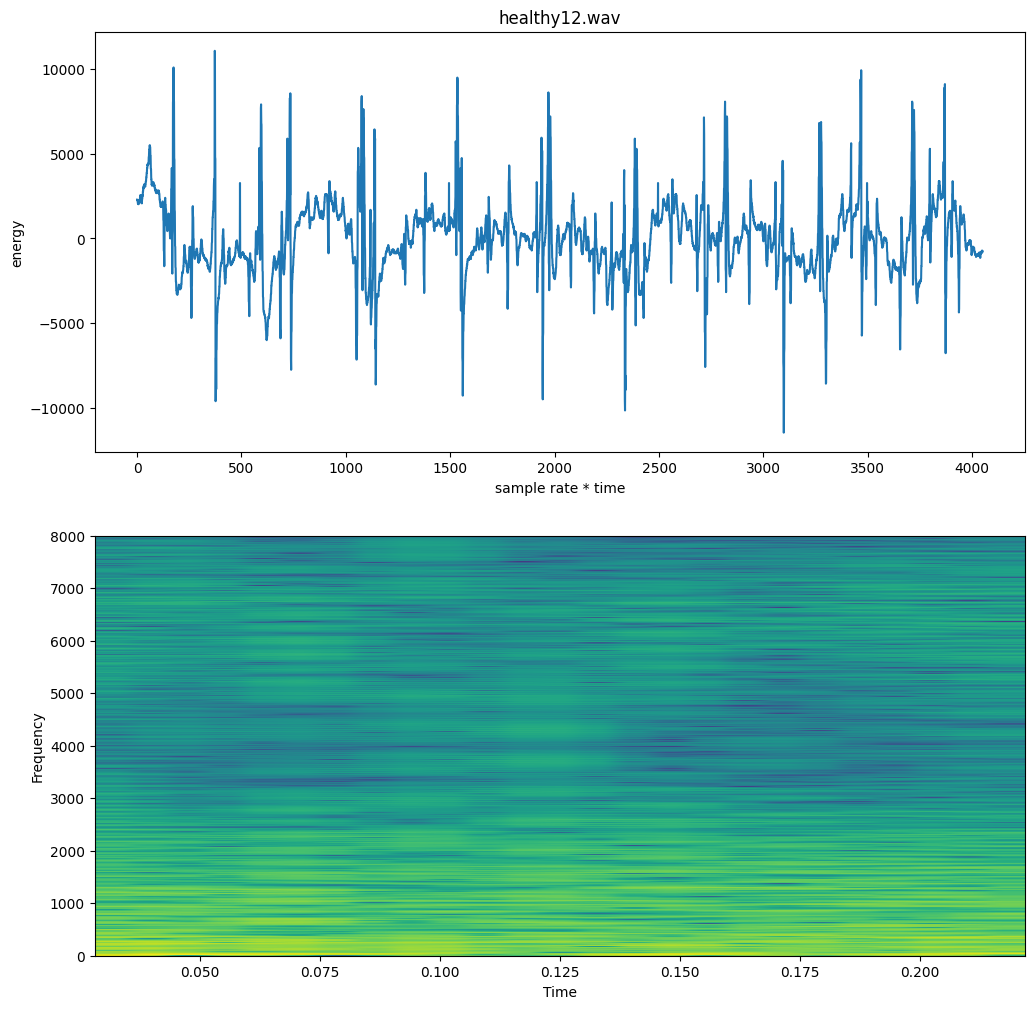

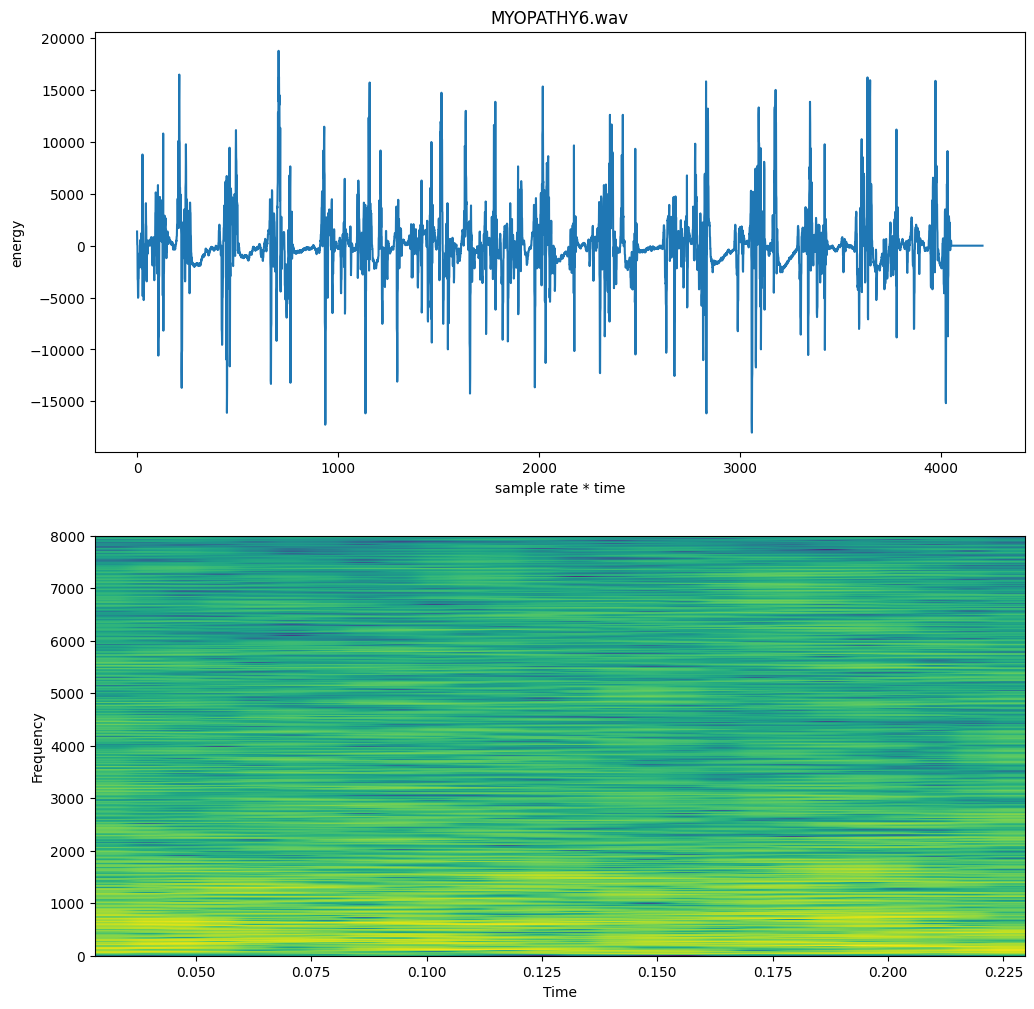

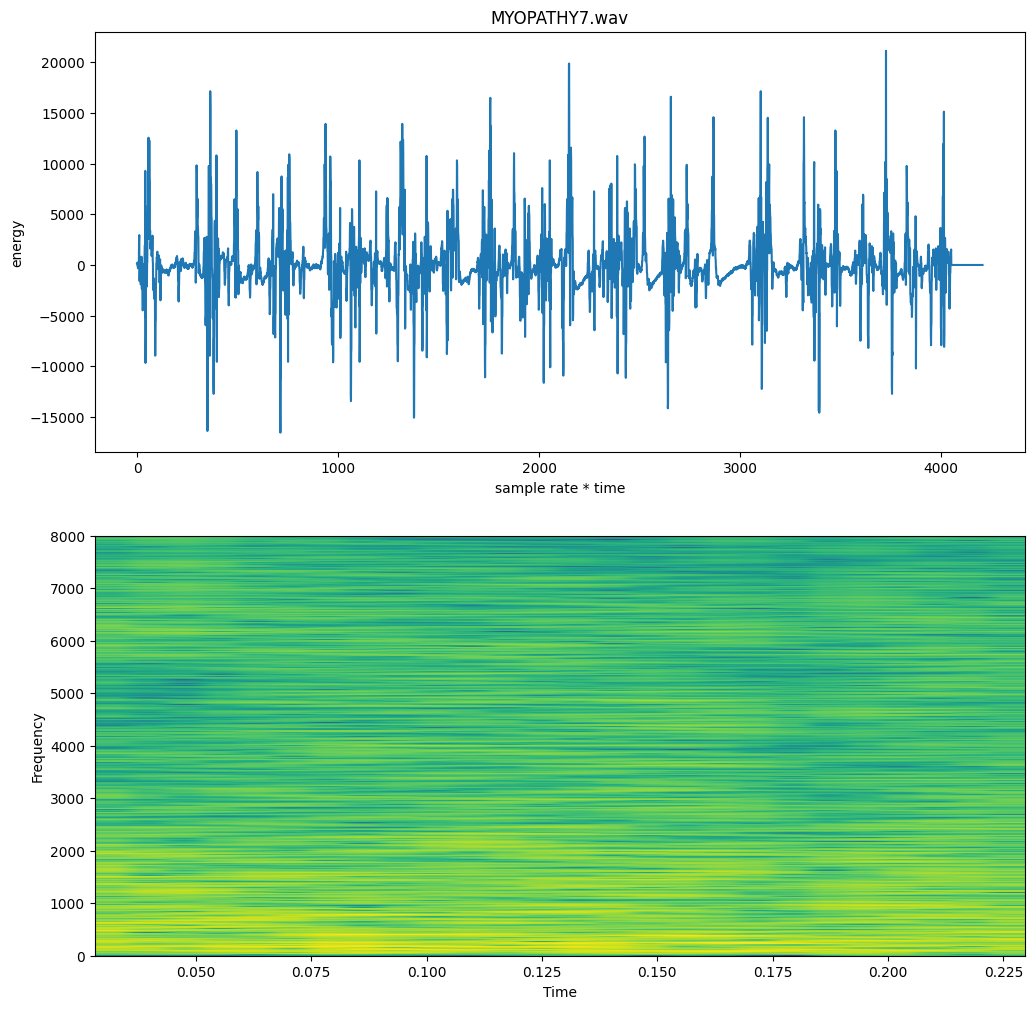

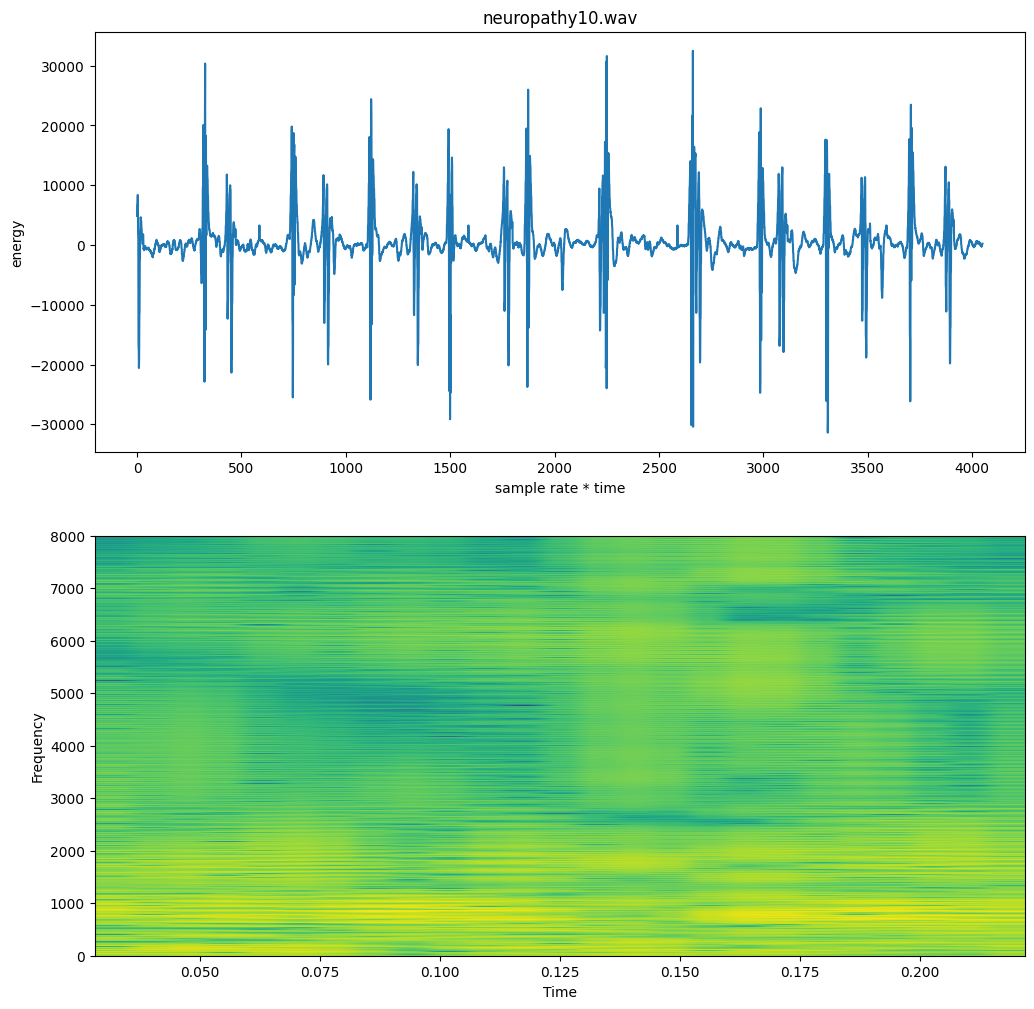

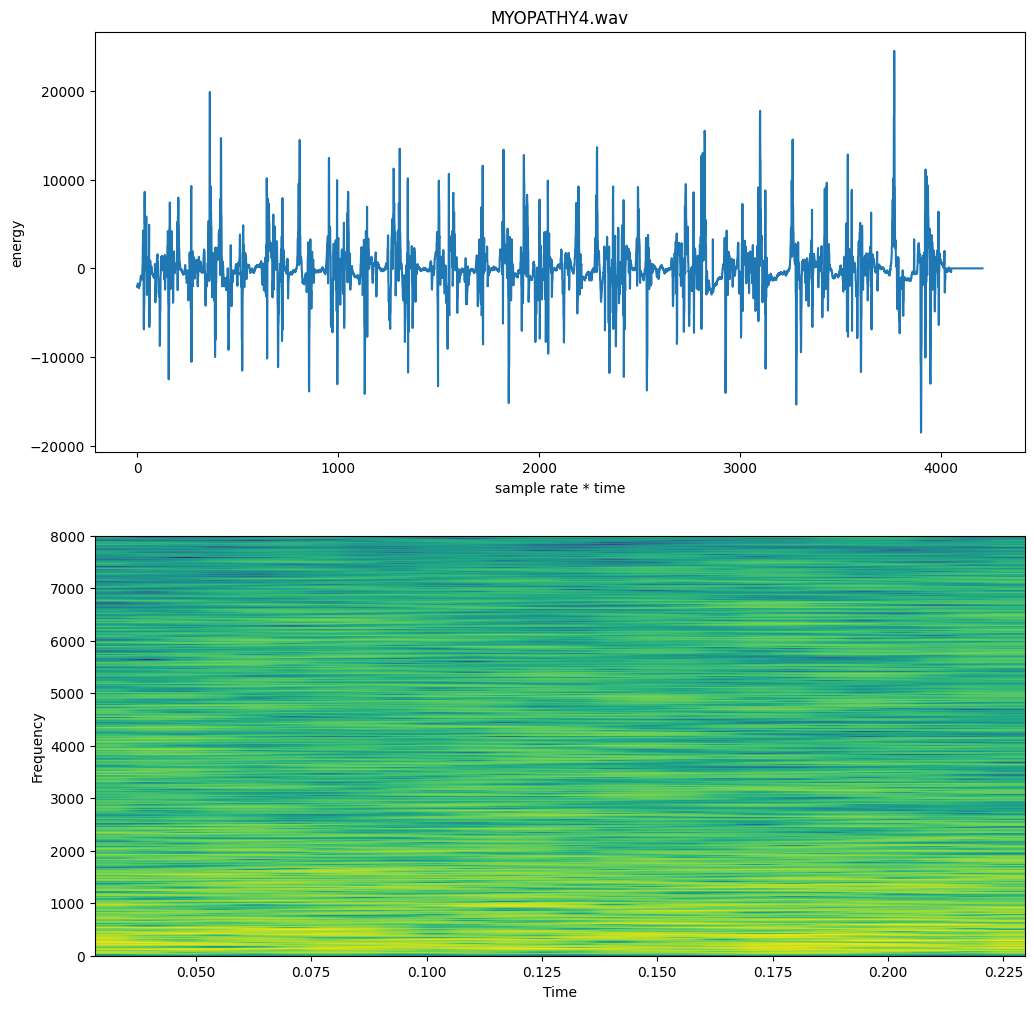

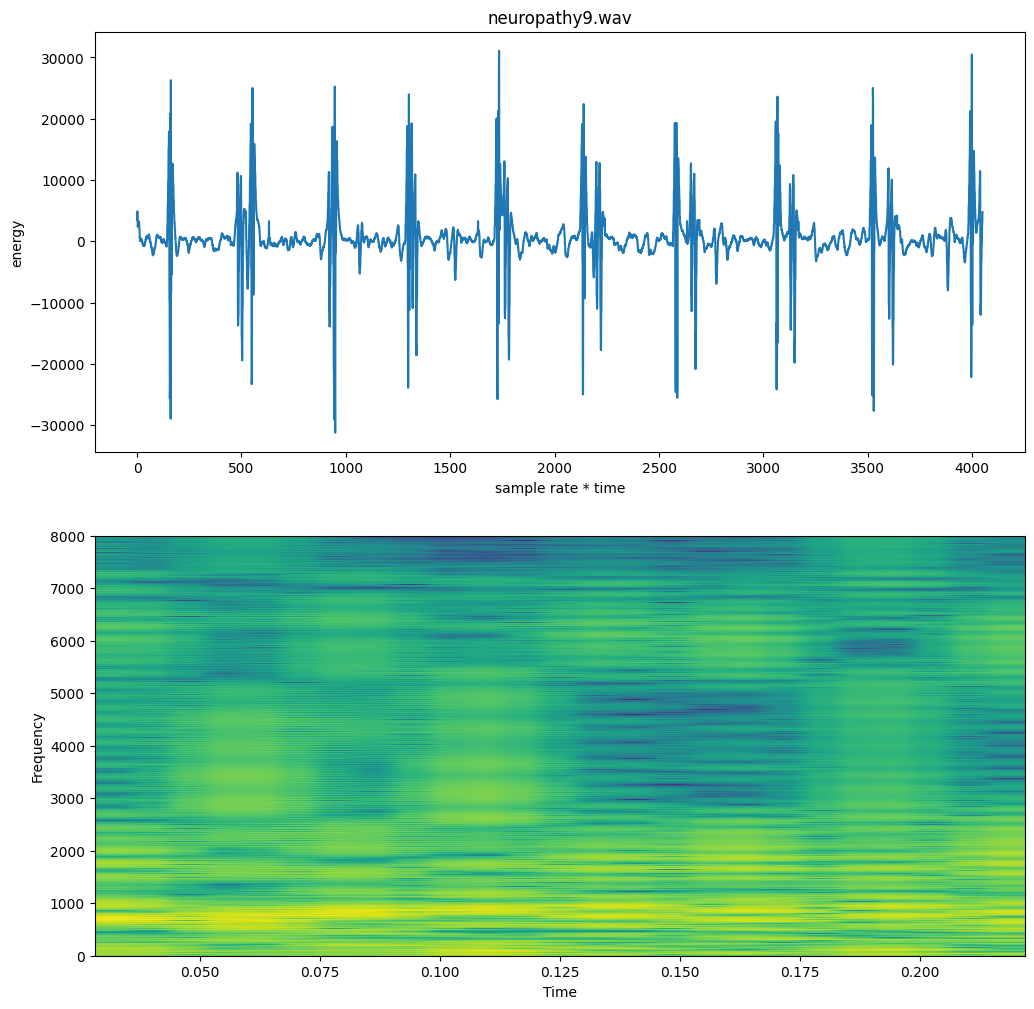

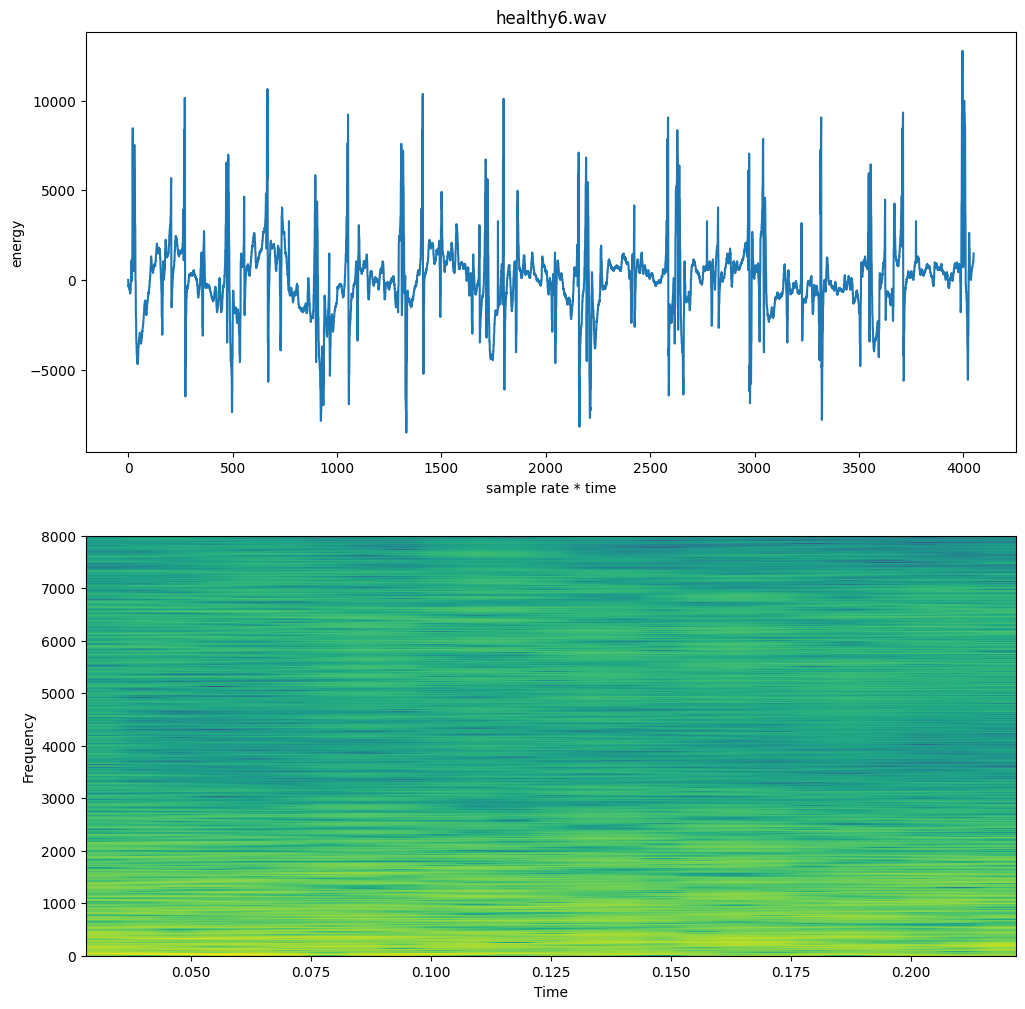

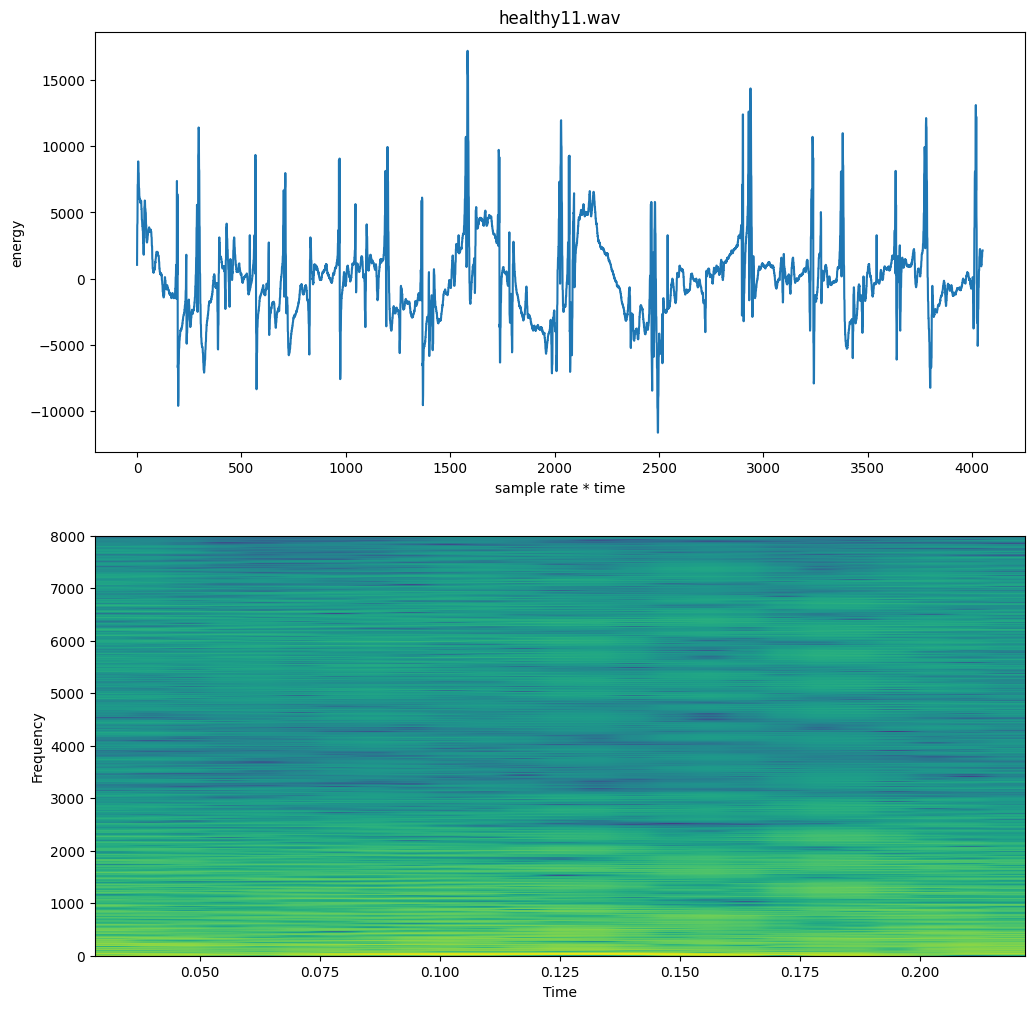

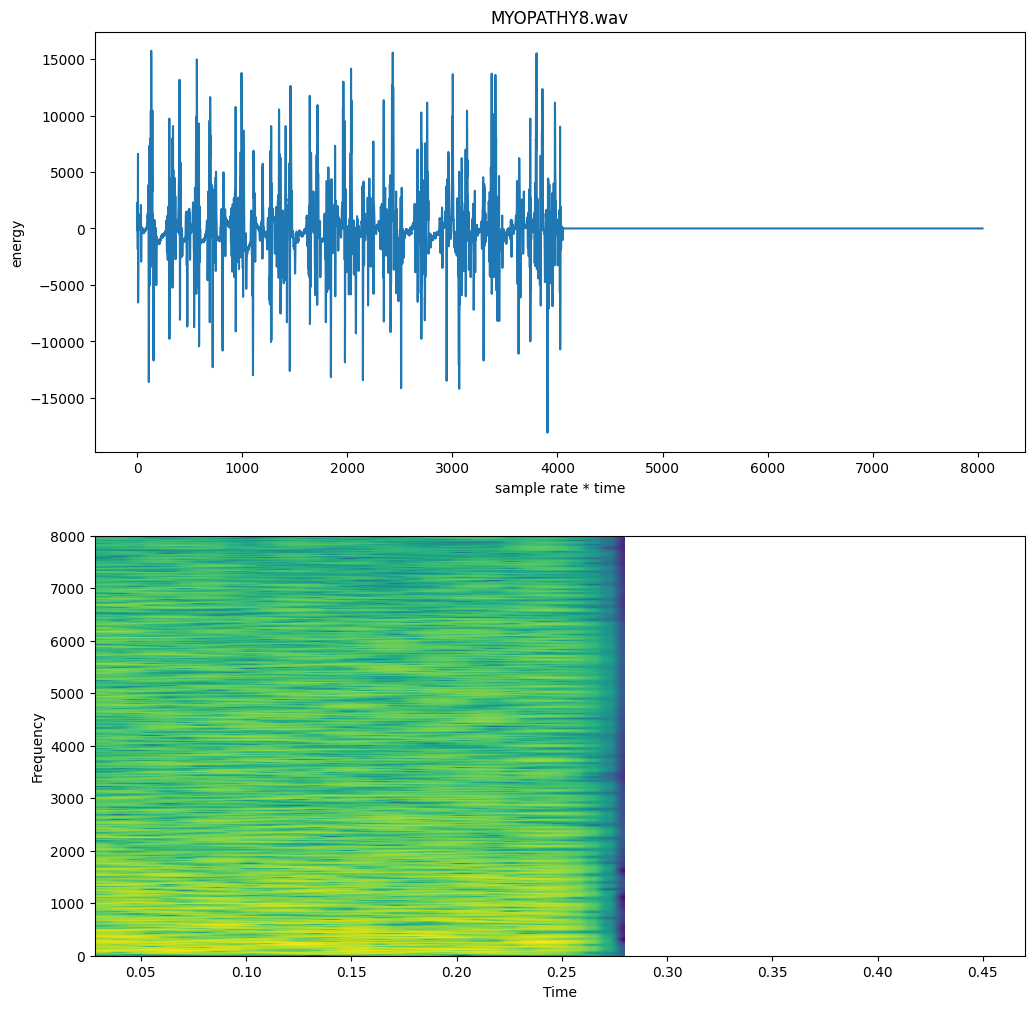

In [ ]:
for i in range(12):
    signal_wave = wave.open(os.path.join(INPUT_DIRECTORY, parent_list[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

In [ ]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

In [ ]:
if not os.path.exists(os.path.join(OUTPUT_DIRECTORY, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIRECTORY, 'audio-images'))

NameError: ignored

In [ ]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

In [ ]:
for filename in os.listdir(INPUT_DIRECTORY):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIRECTORY, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIRECTORY, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

In [ ]:
path_list = os.listdir(os.path.join(OUTPUT_DIRECTORY, 'audio-images'))
print("Classes: \n")
for i in range(3):
    print(path_list[i])
path_list = os.listdir(os.path.join(OUTPUT_DIRECTORY, 'audio-images/class_M'))
print("\nA few example files: \n")
for i in range(3):
    print(path_list[i])

Classes: 

class_h
class_n
class_M

A few example files: 

MYOPATHY11.png
MYOPATHY6.png
MYOPATHY9.png


BUILDING MODEL FROM HERE


In [ ]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
MYOPATHY = os.path.join('Input', 'MYOPATHY1.wav')
NOT_MYOPATHY = os.path.join('Input', 'healthy1.wav')

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(MYOPATHY)
nwave = load_wav_16k_mono(NOT_MYOPATHY)

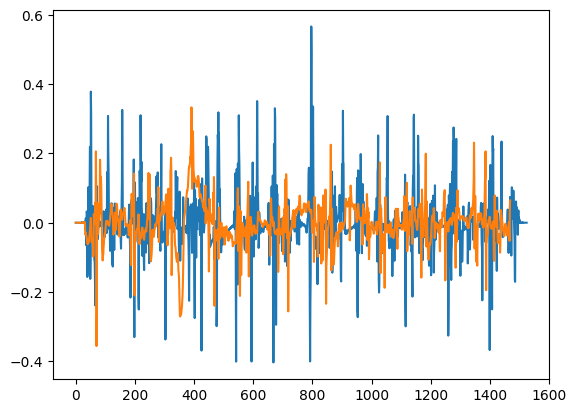

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 3

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIRECTORY, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

Found 35 files belonging to 3 classes.
Using 28 files for training.


In [ ]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIRECTORY, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 35 files belonging to 3 classes.
Using 7 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['class_M', 'class_h', 'class_n']


In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/Output/audio-images')

Found 35 files belonging to 3 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

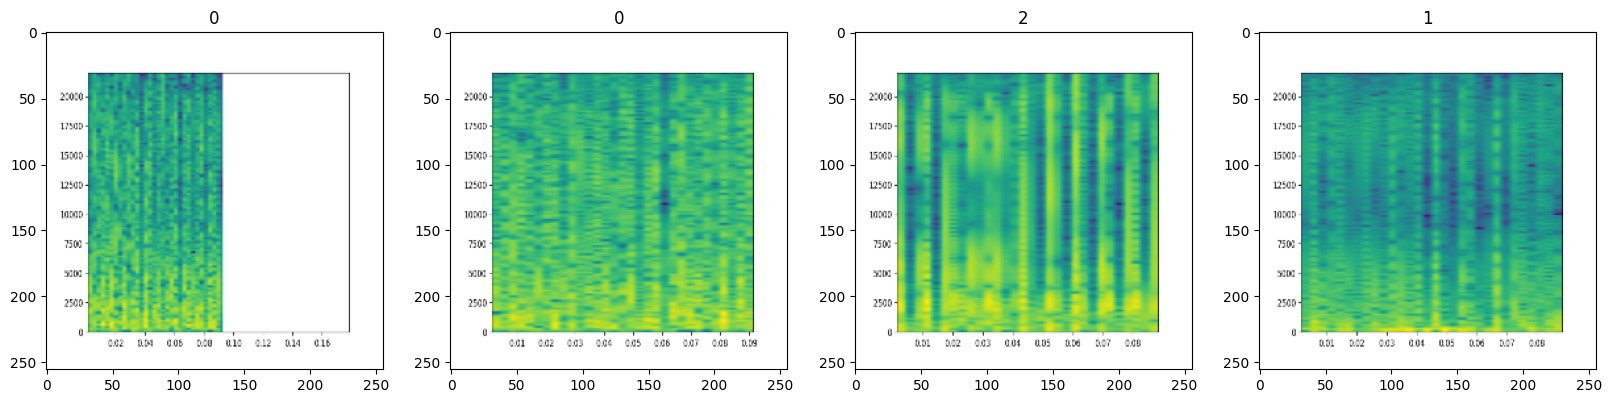

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/256, y))

In [ ]:
data.as_numpy_iterator().next()

(array([[[[0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          ...,
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375]],
 
         [[0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          ...,
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375]],
 
         [[0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          ...,
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375],
          [0.99609375, 0.99609375, 0.99609375]],
 
         ...,
 
         [[0.99609375, 0.99609375, 0.99609375],
          [0.99609

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train_size

1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

In [ ]:
def prepare(ds, augment=False):
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_21 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 64)        18496     
                                                      

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
Myo = model.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks=[tensorboard_callback])

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.1265 - accuracy: 0.1071 - val_loss: 247.4398 - val_accuracy: 0.1429
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.1247 - accuracy: 0.9286 - val_loss: 179.1415 - val_accuracy: 0.1429
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 142.1521 - val_accuracy: 0.1429
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 120.5575 - val_accuracy: 0.1429
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 105.5082 - val_accuracy: 0.1429
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 94.2345 - val_accuracy: 0.1429
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 85.3359 - val_accuracy: 0.1429
Epoch 8/10
1/1 [=============

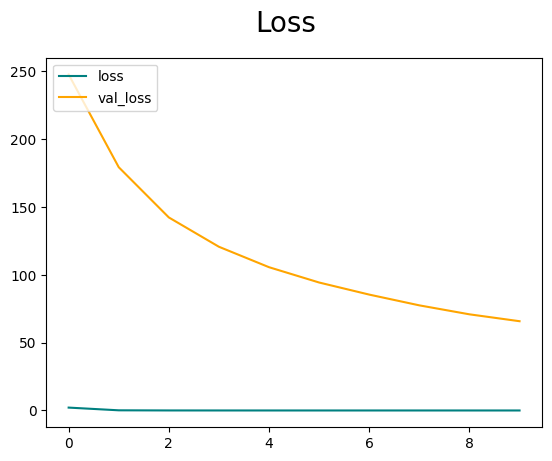

In [ ]:
fig = plt.figure()
plt.plot(Myo.history['loss'], color='teal', label='loss')
plt.plot(Myo.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

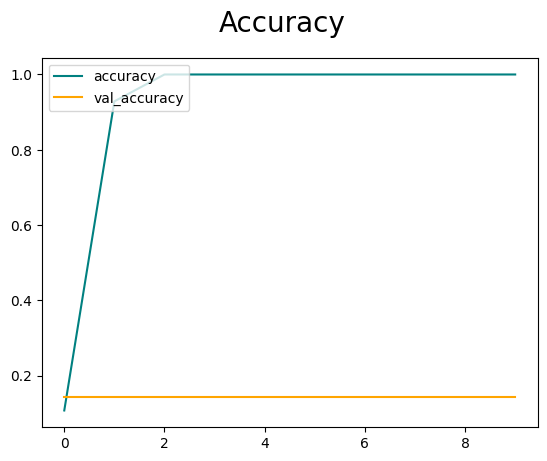

In [ ]:
fig = plt.figure()
plt.plot(Myo.history['accuracy'], color='teal', label='accuracy')
plt.plot(Myo.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
image = '/content/Output/audio-images/class_n/neuropathy1.png'
input_width, input_height = 256, 256
normalized_image = resized_image.astype(np.float32) / 255.0
input_data = np.expand_dims(normalized_image, axis=0)


In [ ]:
predictions = model.predict(input_data)


1/1 [==============================] - 0s 37ms/step


In [ ]:
class_index = np.argmax(predictions)
class_probability = predictions[0, class_index]
class_label = "Healthy"
text = f"{class_label}: {class_probability * 100:.2f}%"

In [ ]:
print(text)

Myopathy: 99.82%


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.sav'))

In [ ]:
new_model = load_model('imageclassifier.sav')

OSError: ignored